# Expanding Variable Cluster Timeline

Author: Sofia Ingersoll 5 May 2024

## Increaseing Timeline
Loading files in 4, 500 cluster chunks 
`campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0113.clm2.h0.1995-02-01-00000.nc`

In [1]:
import xarray as xr
import pickle
from utils import * 

In [2]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 30)
# apply peer2peer network communication across multiple devices
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.80:38207,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
def read_all_simulations2(var):
    '''Prepare cluster list and read to create ensemble(group of data)
    Use preprocess to select only certain dimension and a variable'''
    # Define the list of lists
    cluster_lists = [
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.1995-02-01-00000.nc'))[1:],
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2000-02-01-00000.nc'))[1:],
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2005-02-01-00000.nc'))[1:],
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2010-02-01-00000.nc'))[1:]
    ]
    
    def preprocess(ds, var):
        '''using this function in xr.open_mfdataset as preprocess
        ensures that when only these four things are selected 
        before the data is combined'''
        return ds[['lat', 'lon', 'time', var]]
    
    #read the list and load it for the notebook
    ds = xr.open_mfdataset( cluster_lists, 
                            combine='nested',
                           # lambda allows us to call the predefined preprocess on the ds
                            preprocess = lambda ds: preprocess(ds, var),
                            parallel= True, 
                            concat_dim= ["time", "ens"])
    return ds

In [4]:
# this ran and the outputs are closer to what we expect
# WE OFFICIALLY HAVE 1995 - 2015
ds = read_all_simulations2("LNC")

In [5]:
ds

<xarray.Dataset> Size: 192MB
Dimensions:  (lat: 96, lon: 144, time: 240, ens: 500, gridcell: 400)
Coordinates:
  * lat      (lat) float32 384B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 2kB 1995-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    LNC      (ens, time, gridcell) float32 192MB dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 08/09/23 23:29:43
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_transient_LHC0001.clm...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

### Testing Other Functions!

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# This is where 
# read_all_simulations appears in wkflw
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def subset_var_cluster2(var):
    '''Subset the selected variable 
    (s) between 2005-2010 [for now, will be time range]
    as a xr.da.'''
    
    # Read in and wrangle user selected variable cluster
    da_v = read_all_simulations2(var)
    # feb. ncar time bug
    da = fix_time(da_v)
    # convert xr.ds to xr.da
    da = da[var]

    return da.compute()

In [7]:
def read_n_wrangle2(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # store user-inputs as global variables
    # will call later for plotting
    global param_name, var_name
    param_name = param
    var_name = var
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # pull in parameter data
    params = param_wrangling()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("saves", f"{var}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----    Subset User Selection Funct     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    var_da = subset_var_cluster2(var)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----      Subset Var Wrangle Funct      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    var_avg = wrangle_var_cluster(var_da)

        #you ought to convert the data array to dataset before writing to file
    ds = var_avg.to_dataset(name = var)
    # note that this will throw error if you try to overwrite existing files
    ds.to_netcdf('saves/'+var+'.nc') 

    return params, var_avg, param_name, var_name

In [8]:
# this takes about 2 minutes to run
param2, var2, param_name, var_name = read_n_wrangle2("leafcn","LNC")

In [9]:
var2.shape
var2

<xarray.DataArray (ens: 500)> Size: 4kB
array([1.00483139, 0.94270426, 0.80605579, 1.1128554 , 0.80453896,
       0.89947509, 1.17311634, 1.07390253, 1.15246407, 0.95042113,
       0.92575337, 0.88109323, 0.80037626, 0.69054404, 0.91848529,
       0.65470052, 0.84413694, 0.74928195, 0.76841898, 1.00849537,
       1.03304884, 0.96510496, 0.64508573, 0.62692846, 0.8113084 ,
       0.89804134, 0.68622747, 0.99803847, 0.88498184, 0.84298645,
       0.5668954 , 0.7940038 , 0.90598016, 0.83229929, 0.99533558,
       0.71565572, 1.14975743, 0.92956121, 0.70375154, 0.58010059,
       1.4550065 , 0.88190826, 0.86925358, 0.80250983, 1.11572008,
       0.74331942, 1.28283612, 0.73988352, 0.75966279, 0.65763585,
       0.8046558 , 0.95892461, 0.88531088, 0.65444614, 0.97957942,
       0.7479346 , 0.71812983, 1.06881471, 0.90273297, 0.79920299,
       0.62173263, 0.98091734, 1.12732736, 1.33402347, 0.68673104,
       0.6494072 , 0.46486671, 1.07479399, 0.74369839, 0.69711758,
       0.79923297, 0.81781476, 0.79842728, 0.7160391 , 1.0134065 ,
       1.0762292 , 0.58411771, 0.97489135, 1.00316675, 0.8974827 ,
       0.9576883 , 0.70769551, 0.60089885, 0.775058  , 0.6856202 ,
       0.80232722, 1.00826583, 0.67553101, 0.61081382, 1.02827774,
       1.1391003 , 0.90146549, 1.22777658, 0.79298147, 0.68799567,
       0.95485484, 0.624383  , 0.92874903, 0.56012138, 0.73627882,
...
       0.5250748 , 0.91113726, 0.51218591, 0.90333593, 0.7186534 ,
       0.79830829, 0.85684721, 1.081304  , 1.09184664, 1.03069391,
       1.09396823, 1.03482179, 1.0899302 , 0.63589392, 0.99895348,
       1.08101282, 0.59851473, 0.95873581, 1.30624742, 0.68579923,
       0.73116038, 0.85341234, 0.89935879, 0.9106108 , 0.80627532,
       1.01398352, 0.72410183, 0.5902345 , 0.71129542, 0.6737649 ,
       0.9677413 , 0.85272023, 0.71096648, 0.87338698, 0.71629044,
       0.6119169 , 0.94932187, 0.60251337, 0.81745168, 0.87549494,
       0.75713172, 0.78749476, 0.86230202, 0.68574534, 0.55478205,
       0.98228629, 0.69014263, 0.56071103, 1.04437843, 0.84640924,
       0.93341076, 0.83494983, 1.08701967, 0.86300214, 0.66339375,
       0.51969231, 1.07132359, 0.58470903, 0.89186424, 0.67423432,
       0.93366672, 1.22330245, 0.79440031, 0.9491069 , 0.58697589,
       0.77379369, 0.65677785, 1.01295791, 0.55110768, 0.71357092,
       1.11226806, 0.90559835, 0.96262743, 0.99207887, 0.63474586,
       0.92134597, 0.72771233, 0.64391178, 0.89087412, 0.57595648,
       0.94136548, 0.53802087, 1.24665817, 1.00894514, 0.93981805,
       1.10759742, 0.94279827, 1.42957106, 0.65637618, 1.13095786,
       0.59948692, 0.965988  , 0.8184049 , 0.82870161, 0.67934924,
       0.74236659, 0.76305159, 0.96460325, 0.52084213, 0.96982045])
Dimensions without coordinates: ens

**The var dim post wrangling is ens.**

In [10]:
# this takes about 2 minutes to run
param, var, param_name, var_name = read_n_wrangle("leafcn","LNC")

In [11]:
var.shape
var

<xarray.DataArray 'LNC' (ens: 500)> Size: 4kB
[500 values with dtype=float64]
Dimensions without coordinates: ens

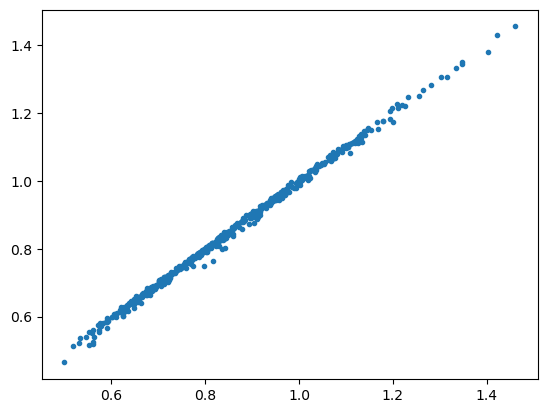

In [12]:
plt.plot(var,var2,'.')

### Expanding Emulator Capabilities
We want to iterate through all perturbed parameters to train the emulator

In [17]:
def train_emulator2(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----   Load Pickled Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   # work in progress in GaiaFuture/Scripts/ML/Gaussian/gpr_pickling.ipynb
    # if it's already been queried and saved, pull it!
    # tis only names properly when inside dashboard function
    # commenting out now and adapting bc var is xr.da in this case
    filename = os.path.join("emulation_results", f"gpr_model_{var_name}_{param_name}.sav")
   
    #if os.path.exists(filename):
        # load the model from disk
     #   loaded_model = pickle.load(open(filename, 'rb'))
        
   # else:
    #    print(f"Emulator is running, this may take a few moments")
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Split Data 90/10        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # data for splitting
    X_train, X_test, y_train, y_test = train_test_split(param,
                                                        var,
                                                        test_size=0.2,
                                                        # setting a seed
                                                        random_state=0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Kernel Specs No Tuning    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # initiate the model without tuning
    kernel = ConstantKernel(constant_value = 3,
                            constant_value_bounds=(1e-2, 1e4)) \
                  * RBF(length_scale=1, 
                        length_scale_bounds=(1e-4, 1e8))
   
   
     # using an out of the box kernel for now
    gpr_model = GaussianProcessRegressor(kernel=kernel,
                                        # want 20 random starts
                                        n_restarts_optimizer=20,
                                        # setting seed
                                        random_state=99,
                                        normalize_y=True)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit the Model        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Fit the model to the training data
    gpr_model = gpr_model.fit(X_train, y_train)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Get Predictions      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Make predictions
    y_pred, y_std = gpr_model.predict(X_test, return_std=True)


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Collect Metrics      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Verify training score
    #train_score = gpr_model.score(X_train, y_train)

    # Accuracy Score
    #accuracy = accuracy_score(y_test, y_pred)

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate R^2
    r2_emulator = np.corrcoef(y_test, y_pred)[0,1]**2
    
    # Calculate RMSE
    rmse_emulator = np.sqrt(mean_squared_error(y_test, y_pred))

    # Create a DataFrame to store the results for plotting
    results_df = pd.DataFrame({
        'y_pred': y_pred,
        'y_std': y_std,
        'y_test': y_test,
        'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
    })

    # Add metrics to the DataFrame
    results_df['R^2'] = r2_emulator
    results_df['RMSE'] = rmse_emulator
    #results_df['Accuracy Score'] = accuracy
    results_df['Mean Absolute Error'] = mae
    
   
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Pickle Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # save the model to disk
    pickle.dump(gpr_model, open(filename, 'wb')) 
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----        Print Metrics         ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Print Training Metrics
    print("R^2:", r2_emulator)
    print("RMSE:", rmse_emulator)
    print("Mean Absolute Error:", mae)
   # print("Training Score:", train_score)
    
    return gpr_model, y_pred, y_std, y_test, X_test, r2_emulator

In [18]:
gpr_model, y_pred, y_std, y_test, X_test, r2_emulator = train_emulator2(param2, var2)

R^2: 0.9415520360334377
RMSE: 0.04752375585377918
Mean Absolute Error: 0.03799581460434838


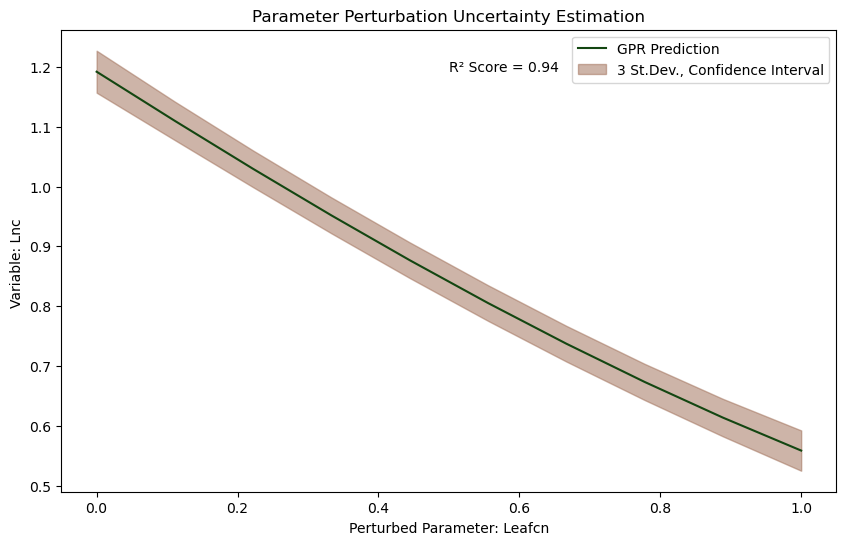

In [19]:
plot_emulator(gpr_model, y_test, r2_emulator)

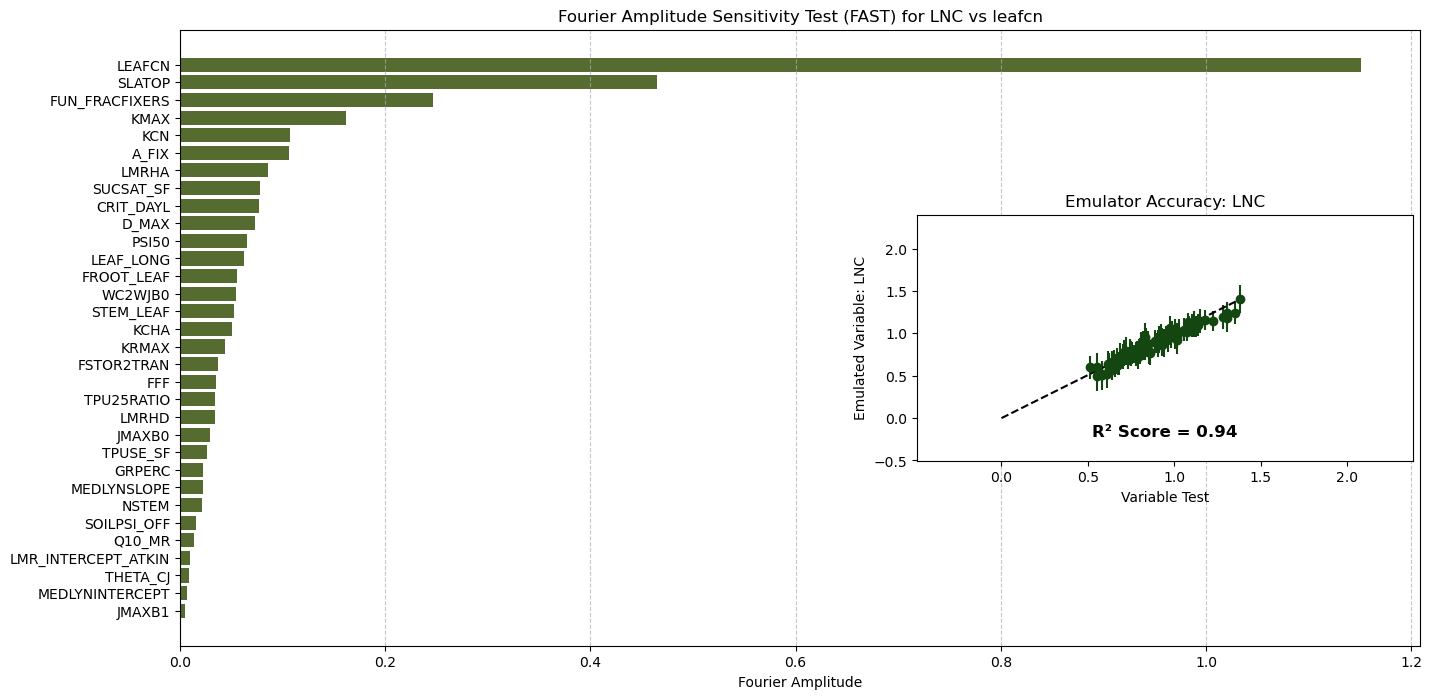

In [15]:
plot_FAST_accuracy(gpr_model, r2_emulator, y_test, y_pred, y_std)

### Improving Func Integration 
It would be beneficial to move our if else statement outside of the `read_n_wrangle()` and directly into the `read_all_simulations()` because it doesn't need to depend on the parameter / variable combination bc the param data is the same for all sims. 

Next step, adding this into the function above once we're able to improve the computational speed of `read_all_simulations()`

In [ ]:
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("saves", f"{var}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")